This code is for looking for a single event's spacepoints and plotting them

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [4]:
def plot(file_name, group_label, index):

    with h5py.File(file_name, 'r') as f:

        sp = f[group_label]

        _, starting_index, num_points, run, subrun, event, description = sp['sequence_info_filtered'][index]
        points = sp['point_info_filtered'][starting_index:starting_index+num_points]

    print(f'{starting_index}, {num_points}')
    print(f'{run}, {subrun}, {event}')
    print(f'{points[0]}')
    print(description)

    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    integral = points[:,3]

    # fig = plt.figure(dpi=200)
    # ax = fig.add_subplot(projection='3d')
    # ax.scatter(x,y,z,c=integral, cmap='viridis', alpha=1, marker='.')
    # ax.set_xlabel('x [cm]')
    # ax.set_ylabel('y [cm]')
    # ax.set_zlabel('z [cm]')
    # ax.set_aspect('equal')
    # ax.view_init(elev=15, azim=160)
    # fig.tight_layout()

    df = pd.DataFrame({'x':x, 'y':y, 'z':z, 'q':integral})
   

    plotly_fig = px.scatter_3d(df, x='x', y='y', z='z', size='q', color='q')
    plotly_fig.update_layout(width=2000,height=1800,margin=dict(l=0, r=0, b=0, t=0),
                             scene_camera=dict(
        eye=dict(x=1.5, y=-1.7, z=1.2)  # Position of the camera
    ))
    plotly_fig.update_traces(marker=dict(line=dict(width=0)))
    plotly_fig.show()
    


def plot_hist_volume(file_name, group, index):

    with h5py.File(file_name, 'r') as f:

        sp = f['spacepoint_table']

        starting_index, num_points = sp['metadata'][index]
        run, subrun, event = sp['event_id'][starting_index]
        points = sp['position'][starting_index:starting_index+num_points]

    print(f'{starting_index}, {num_points}')
    print(f'{run}, {subrun}, {event}')
    print(f'{points[0]}')

    print(points.transpose())

    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    buffer = 10
    num_bins = 20
    x_bounds = np.linspace(min(x)-buffer, max(x)+buffer, num_bins)
    y_bounds = np.linspace(min(y)-buffer, max(y)+buffer, num_bins)
    z_bounds = np.linspace(min(z)-buffer, max(z)+buffer, num_bins)

    hist3d = np.histogramdd(points, bins=(x_bounds, y_bounds, z_bounds))[0]

    print(np.shape(hist3d))

    print(np.max(hist3d))

    X, Y, Z = np.meshgrid(np.diff(x_bounds), np.diff(y_bounds), np.diff(z_bounds))

    print(np.shape(X))

    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=hist3d.flatten(),
        isomin=0.1,
        isomax=0.8,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=3, # needs to be a large number for good volume rendering
        ))
    fig.show()


In [5]:
plot('../eta-pi-data/eta-pi0-testing.h5', '0 NCPi0', 5)

783, 583
7022, 223, 11156
[ 38.682888    4.0876913 118.7       221.24268  ]
-1


In [28]:
plot('../eta-pi-data/merged_Eta.h5', 2) 

TypeError: plot() missing 1 required positional argument: 'index'

921, 487
7022, 223, 11154
[  31.774115 -109.18843   318.9     ]


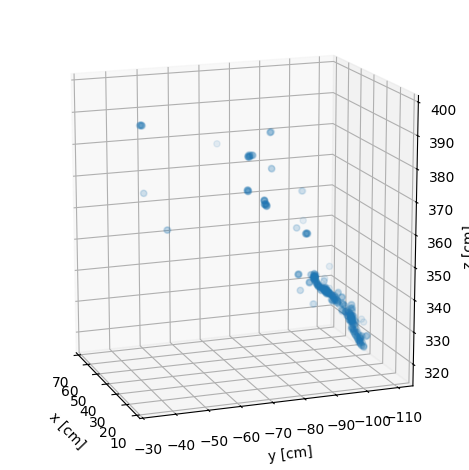

In [36]:
plot('../eta-pi-data/merged_NCPi0.h5', 3) 